# Goal
So the excellent [original kernel](https://www.kaggle.com/ahassaine/pure-image-processing-lb-0-274) put together by [Ali](https://www.kaggle.com/ahassaine) gets 0.274 "without even using the training data" which is a great result, but what if we use the training data.  
## Overview
The idea is to take the parameters found in the original kernel and try to improve them using the IOU score as the ground criteria.
1. Get a cross-validation setup working that gives us a similar value to the 0.274
1. Rewrite the threshold and label methods to take all of their parameters
1. Use scipy.optimize (probably sk-optimize would be better, but we'll keep it simple here) to improve the values
1. Predict and submit

In [176]:
from os.path import join
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import os
import skimage
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
from skimage.color import rgb2grey, rgb2hsv
from skimage import img_as_float, img_as_ubyte
from skimage.morphology import reconstruction
from skimage import img_as_float, exposure
from skimage.util import invert

from sklearn.model_selection import train_test_split
from skimage.morphology import label


from scipy.optimize import minimize
from tqdm import tqdm

import utils
from utils import iou_metric, diagnose_errors, add_contour, show_img, plot_img_and_hist, show_with_contour

dsb_data_dir = os.path.join('..', '..', 'input')
stage_label = 'stage1'

In [175]:
utils = reload(utils)

In [2]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
img_id = lambda in_path: in_path.split('/')[-3]
img_type = lambda in_path: in_path.split('/')[-2]
img_group = lambda in_path: in_path.split('/')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('/')[-4].split('_')[0]
img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(2)
img_df.describe()

,path,ImageId,ImageType,TrainingSplit,Stage
count,30196,30196,30196,30196,30196
unique,30196,735,2,2,1
top,../../input/stage1_train/04acab7636c4cf61d288a...,a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a98...,masks,train,stage1
freq,1,376,29461,30131,30196


# Process and Import Training Data
Here we load in the training data images and labels. We load the label images into a single index colored integer image.

In [3]:
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]


In [4]:
train_img_df = pd.DataFrame(train_rows)    
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([i*(imread(c_img)>0) for i, c_img in enumerate(in_img_list, 1)], 0), 0)

def read_hist_bw(in_img_list):
    #return rgb2grey(cv2.imread(in_img_list[0]))
    #return rgb2hsv(cv2.imread(in_img_list[0]))[:,:,1]
    return cv2.imread(in_img_list[0])[:,:,1]

In [5]:
%%time
train_img_df['images'] = train_img_df['images'].map(read_hist_bw)
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
train_img_df.sample(1)

CPU times: user 1min 38s, sys: 53 s, total: 2min 31s
Wall time: 2min 34s


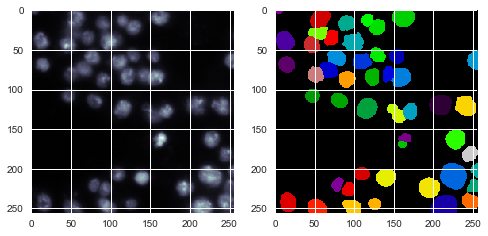

In [22]:
for _, c_row in train_img_df.sample(1).iterrows():
    c_row = train_img_df.iloc[333]
    ex = c_row
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
    ax1.imshow(c_row['images'], cmap = 'bone')
    ax2.imshow(c_row['masks'], cmap = 'nipy_spectral')
    ex = c_row

In [7]:
train_split_df, valid_split_df = train_test_split(train_img_df, 
                                                  test_size = 0.2, 
                                                  random_state = 2018,
                                                  # ensures both splits have the different sized images
                                                  stratify = train_img_df['images'].map(lambda x: '{}'.format(np.shape))
                                                 )
print('train', train_split_df.shape, 'valid', valid_split_df.shape)


('train', (536, 4), 'valid', (134, 4))


# Wrap Everything Up
We have a single function to evaluate the IOU of a model on a dataset

In [ ]:
def calculate_iou(in_df, thresh_func):
    pred_masks = in_df['images'].map(thresh_func).values
    gt_masks = in_df['masks'].values
    all_ious = [iou_metric(cur_gt, cur_pred, print_table=False) for cur_gt, cur_pred in 
            zip(gt_masks, pred_masks)]
    return np.mean(all_ious)

ImageId        7b5987a24dd57325e82812371b3f4df7edc528e0526754...
Stage                                                     stage1
images         [[28, 37, 43, 47, 43, 37, 34, 34, 32, 21, 13, ...
masks          [[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0,...
p                                                      0.0958904
p_loc                                                   0.536763
mean_prec                                               0.991051
mean_rec                                                0.728164
missed_rate                                            0.0136986
extra_rate                                                     0
oseg                                                           0
useg                                                    0.109589
Name: 333, dtype: object


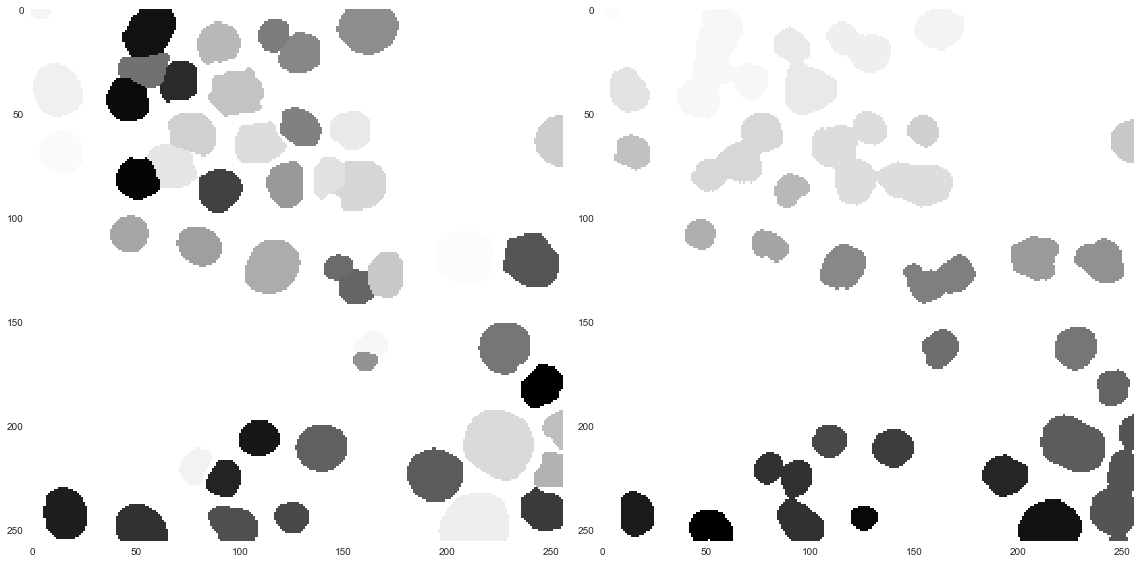

0.157836695608


In [27]:
# hier
print ex
pred_masks = ali_pipeline(ex['images'])
gt_masks = ex['masks']
show_img([gt_masks, pred_masks])
print iou_metric(gt_masks, pred_masks, print_table=False) 

# Define a Parametric Model
Here we take the basic Gabor pipeline and allow the important parameters to be adjusted so they can consequently be optimized

In [208]:
def parametric_pipeline(img,
                invert_thresh_pd = 10,
                circle_size = 7,
                h=0.87
                ):
    
    circle_size = np.clip(int(circle_size), 1, 30)
    
    # Invert the image in case the objects of interest are in the dark side
        
    img_grey = img_as_ubyte(img)
    img_th = cv2.threshold(img_grey,0,255,cv2.THRESH_OTSU)[1]

    if(np.sum(img_th==255)>((invert_thresh_pd/10.0)*np.sum(img_th==0))):
        img=invert(img)
        
    # reconstruction with dilation
    img_float = img_as_float(img)
    seed = img_float - h
    dilated = reconstruction(seed, img_float, method='dilation')
    hdome = img_float - dilated
    #print 'hdome', hdome.min(), hdome.max()
    #print 'image', img.min(), img.max()
    #print 'dilated', dilated.min(), dilated.max()
    #show_img([img,dilated,hdome])
    #hdome = img
    
    # NOTE: the ali pipeline does the opening before flipping, makes a difference
    # at the edges!
    
    # morphological opening (size tuned on training data)
    circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(circle_size, circle_size))
    img_open= cv2.morphologyEx(hdome, cv2.MORPH_OPEN, circle7)
    
    # thresholding
    # isodata thresholding is comparable to otsu ...
    #Otsu thresholding
    #try:
    #    th = skimage.filters.threshold_local(img_open)
    #img_th=cv2.threshold(img_open,th,255,cv2.THRESH_BINARY)[1]
    #except:
    
    img_grey = img_as_ubyte(img_open)
    img_th = cv2.threshold(img_grey,0,255,cv2.THRESH_OTSU)[1]
    
    # second morphological opening (on binary image this time)
    bin_open = cv2.morphologyEx(img_th, cv2.MORPH_OPEN, circle7)
    
    #ll = bin_open
    # watershed segmentation
    #img_dist = ndimage.distance_transform_edt(ll)
    #local_maxi = peak_local_max(img_dist,labels=ll,
    #                        min_distance=min_distance,
    #                            footprint=np.ones((20,20)),
    #                         indices=False)
    #markers = ndi.label(local_maxi)[0]
    
    #cc = watershed(-img_dist, markers, mask=ll,compactness=0)
    #connected components
    cc=cv2.connectedComponents(bin_open)[1]
    if cc is None:
        print 'ERROR NONE'
    #cc=segment_on_dt(bin_open,20)
    return cc


# original, verified to be the same as ali
def parametric_pipeline_orig(img_green,
                invert_thresh_pd = 10,
                circle_size_x = 7,
                circle_size_y = 7,
                ):
    circle_size_x = np.clip(int(circle_size_x), 1, 30)
    circle_size_y = np.clip(int(circle_size_y), 1, 30)
    
    #green channel happends to produce slightly better results
    #than the grayscale image and other channels
    #morphological opening (size tuned on training data)
    circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(circle_size_x, circle_size_y))
    img_open=cv2.morphologyEx(img_green, cv2.MORPH_OPEN, circle7)
    #Otsu thresholding
    img_th=cv2.threshold(img_open,0,255,cv2.THRESH_OTSU)[1]
    #Invert the image in case the objects of interest are in the dark side
    if(np.sum(img_th==255)>((invert_thresh_pd/10.0)*np.sum(img_th==0))):
        img_th=cv2.bitwise_not(img_th)
    #second morphological opening (on binary image this time)
    bin_open=cv2.morphologyEx(img_th, cv2.MORPH_OPEN, circle7) 
    #connected components
    cc=cv2.connectedComponents(bin_open)[1]
    #cc=segment_on_dt(bin_open,20)
    return cc

def ali_pipeline(img_green):
    #green channel happends to produce slightly better results
    #than the grayscale image and other channels
    #morphological opening (size tuned on training data)
    circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    img_open=cv2.morphologyEx(img_green, cv2.MORPH_OPEN, circle7)
    #Otsu thresholding
    img_th=cv2.threshold(img_open,0,255,cv2.THRESH_OTSU)[1]
    #Invert the image in case the objects of interest are in the dark side
    if(np.sum(img_th==255)>np.sum(img_th==0)):
        print 'invert ali'
        img_th=cv2.bitwise_not(img_th)
    #second morphological opening (on binary image this time)
    bin_open=cv2.morphologyEx(img_th, cv2.MORPH_OPEN, circle7) 
    #connected components
    cc=cv2.connectedComponents(bin_open)[1]
    #cc=segment_on_dt(bin_open,20)
    return cc

def ali_pipeline_bk(img_green):
    #green channel happends to produce slightly better results
    #than the grayscale image and other channels
    #morphological opening (size tuned on training data)
    circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    img_open=cv2.morphologyEx(img_green, cv2.MORPH_OPEN, circle7)
    #Otsu thresholding
    img_th=cv2.threshold(img_open,0,255,cv2.THRESH_OTSU)[1]
    #Invert the image in case the objects of interest are in the dark side
    if(np.sum(img_th==255)>np.sum(img_th==0)):
        img_th=cv2.bitwise_not(img_th)
    #second morphological opening (on binary image this time)
    bin_open=cv2.morphologyEx(img_th, cv2.MORPH_OPEN, circle7) 
    #connected components
    cc=cv2.connectedComponents(bin_open)[1]
    #cc=segment_on_dt(bin_open,20)
    return #cc

# Single Evaluation over Train Set

In [185]:
print calculate_iou(train_split_df, lambda x: parametric_pipeline(x,10,7,0.87))

0.43827443093


# Single Evaluation over Validation Set

In [ ]:
%%time
print calculate_iou(valid_split_df, lambda x: parametric_pipeline(x,10,7,7))

# Diagnosis

7b5987a24dd57325e82812371b3f4df7edc528e0526754ba94cf3a1ea4df25d2


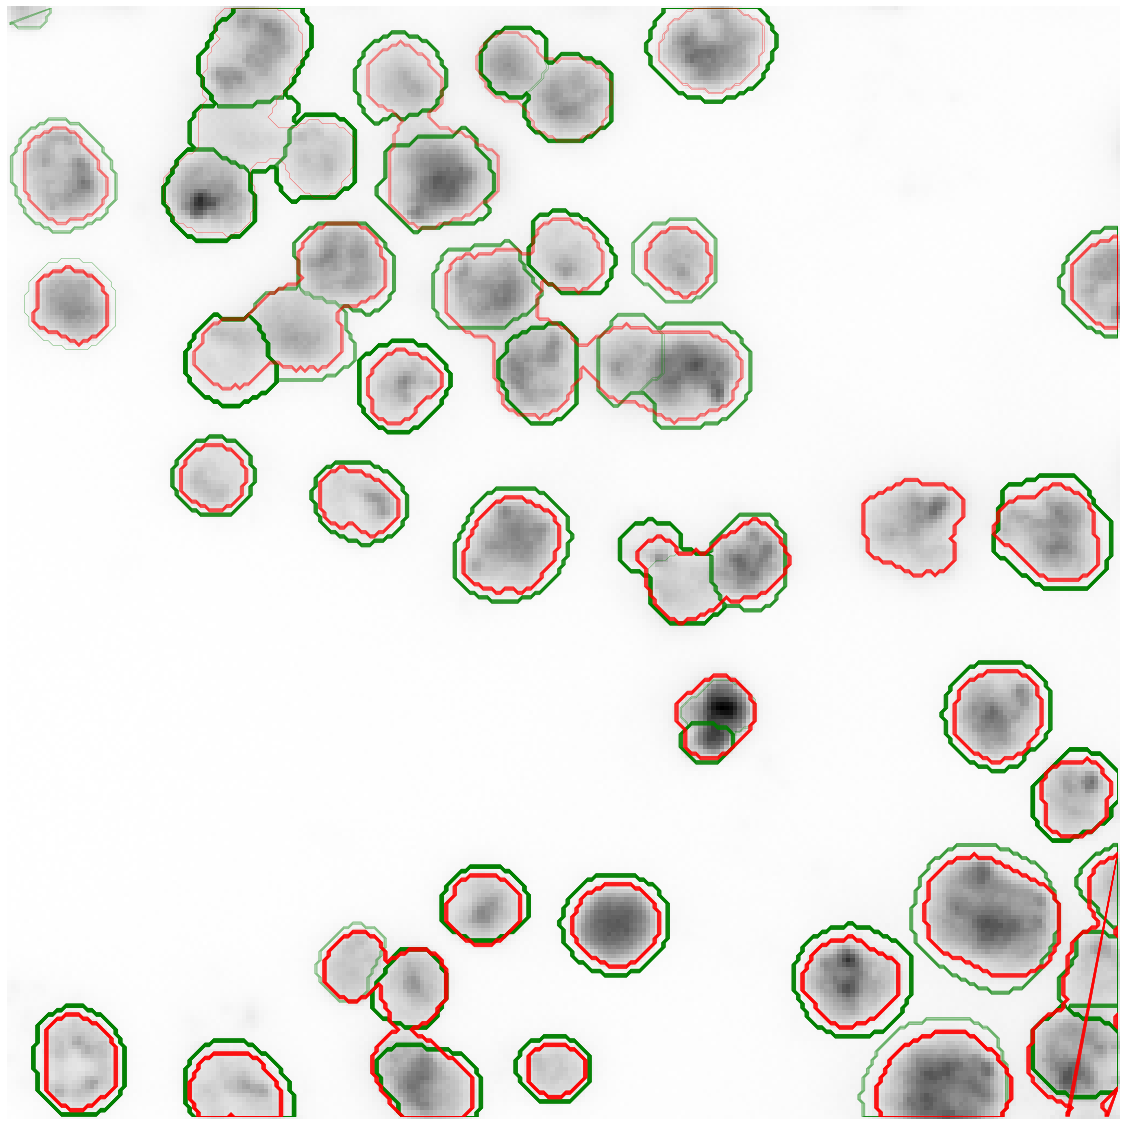

average precision: 9.6 %; max score improvment without mislocations: 53.7 %; missed 1.4 % of positives;  11.0 % of predictions covering multiple objects; segments tend to be too small: pixel precision: 99.1 %, pixel recall: 72.8 %


(0.095890410958904104,
 0.53676265026558578,
 0.99105126082732853,
 0.72816365798056104,
 0.013698630136986301,
 0.0,
 0.0,
 0.1095890410958904)

In [23]:
def diag_fun(row):
     pred_masks = parametric_pipeline(row['images'], 10, 7)
     return diagnose_errors(row['masks'], pred_masks, threshold=0.7, print_message=False)

#diags = [diag_fun(row) for _,row in train_img_df.iterrows()]
#for i, k in enumerate(['p', 'p_loc', 'mean_prec', 'mean_rec', 'missed_rate', 'extra_rate', 'oseg', 'useg']):
#    train_img_df[k] = [x[i] for x in diags]

train_img_df.describe()

thresh = 0.7
sel = 0.0
sel_var = 'p'
#ex = train_img_df[(train_img_df[sel_var]>sel) & (train_img_df[sel_var] <= sel+0.1)].iloc[2]

def show_compare_gt(row, thresh):
    pred_masks = parametric_pipeline(row['images'], 10, 7, 7)
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    ax.grid(None)
    ax.imshow(row['images'])
    add_contour(row['masks'], ax, 'green')
    add_contour(pred_masks, ax, 'red')
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.show()
    return diagnose_errors(ex['masks'], pred_masks, thresh, print_message=True)

print ex['ImageId']

show_compare_gt(ex, thresh)

    
#show_img(ex['images'])


# Singe Example Debugging

invert ali
inv
hdome 0.0 0.87
image 4 255
dilated 0.0156862745098 0.13
0 255 255 0 0 255


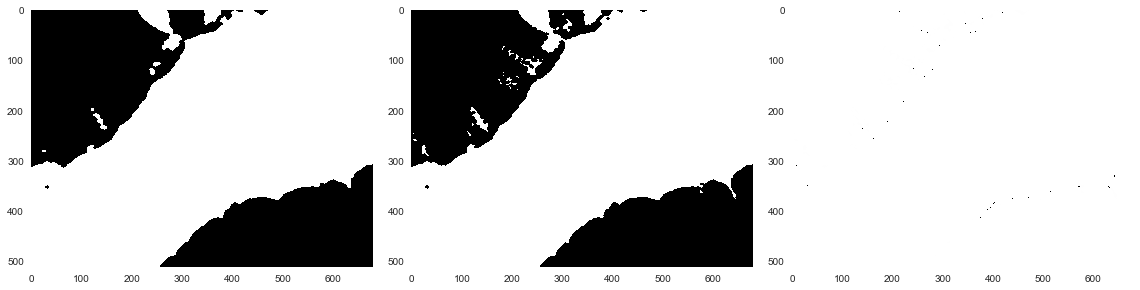

In [170]:
ex = test_img_df.query('ImageId=="17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff"').iloc[0]
#ex = train_img_df.iloc[7]
#print ex['images']
cc_ali = ali_pipeline(ex['images'])
cc_new = parametric_pipeline(ex['images'],1)
diff = cc_new - cc_ali
print diff.min(),diff.max(), cc_new.max(), cc_new.min(), cc_ali.min(), cc_ali.max()
show_img([cc_ali,cc_new,diff])
#plot_img_and_hist(cc_new)
#plot_img_and_hist(cc_ali)
#show_with_contour(ex['images'],cc_new)
#show_with_contour(ex['images'],cc_ali)


In [ ]:
#import skimage
#from scipy import ndimage
#from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.segmentation import random_walker, felzenszwalb

circle_size = 7
invert_thresh_pd = 10
h = 0.1

img = ex['images']

img_grey = img_as_ubyte(img)
img_th = cv2.threshold(img_grey,0,255,cv2.THRESH_OTSU)[1]
if(np.sum(img_th==255)>((invert_thresh_pd/10.0)*np.sum(img_th==0))):
    print 'invert'
    img=invert(img)
        
seed = img - h
dilated = reconstruction(seed, img, method='dilation')
hdome = img - dilated

circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(circle_size, circle_size))
img_open=cv2.morphologyEx(hdome, cv2.MORPH_OPEN, circle7)
#img_th=skimage.filters.threshold_isodata(img_open)

img_grey = img_as_ubyte(img_open)
th, img_th=cv2.threshold(img_grey,0,255,cv2.THRESH_OTSU)
#img_th,img_otsu=cv2.threshold(img_open,img_th,255,cv2.THRESH_BINARY)
print th

#from skimage.filters import try_all_threshold
#fig, ax = try_all_threshold(img_open, figsize=(10, 8), verbose=False)
#plt.show()


#second morphological opening (on binary image this time)
bin_open=cv2.morphologyEx(img_th, cv2.MORPH_OPEN, circle7)
#ll = bin_open # cv2.bitwise_not(bin_open)
#img_dist = ndimage.distance_transform_edt(ll)
 

#ll = bin_open
#local_maxi = peak_local_max(img_dist,labels=ll,
#                            min_distance=7,
#                             indices=False)
#markers = ndi.label(local_maxi)[0]


#labels = watershed(-img_dist, markers, mask=ll,compactness=1)
#labels = random_walker(-img_dist, markers, beta=500)
#abels = felzenszwalb(-img_dist)
#labels = morphological_chan_vese(img_dist)

#print img_dist.max(), img_dist.min()
#print markers.max(), markers.min()

#
#connected components
cc=cv2.connectedComponents(bin_open)[1]
#cc=segment_on_dt(bin_open,20)

#plot_img_and_hist(img)
#plot_img_and_hist(hdome)
#show_img([img,dilated,hdome])
show_img([img,cc])




# Optimization
A very simple optimization routine with no knowledge about morphology, integer steps, iterations or anything else. It just serves as an example of how such a pipeline can be optimized. The random search is also very primitive, a better package would improve this massively.

In [221]:


def parametric_pipeline_wrapper(img, h):
    return parametric_pipeline(img, h, 7, .87)

def sample_parms(parm_ranges):
    return [np.random.choice(np.linspace(l, u, int((u - l)/s + 1))) for l,u,s in parm_ranges]

def random_search_fmin(parm_ranges, random_restart = 5, search_steps = 5):
    results = []
    for it in tqdm(range(random_restart)):
        # pick a new random spot to iterate from
        parms = sample_parms(parm_ranges)
       
        def inv_iou_func(x0):
            try:
                score = calculate_iou(train_split_df, 
                                      lambda x: parametric_pipeline_wrapper(x, *x0))
            except Exception as e:
                print('Arguments:', ' '.join(['%1.3f' % xi for xi in x0]))
                raise ValueError(e)
            print('Arguments:', ' '.join(['%1.3f' % xi for xi in x0]), 
                  'IOU: %2.3f' % score)
            return 1-score # since we are minimizing the result

        opt_params = minimize(inv_iou_func,
                              parms,
                              method='Nelder-Mead',
                              #bounds=((0,1),),
                              options={'xtol':0.005,
                                       'ftol':0.0005,
                              'maxiter':search_steps}
                              )
        
        results.append(opt_params)
      
    n_out = results # sorted(results, key = lambda o: 1.0-float(o.fun))
    return float(n_out[0].fun), n_out


In [ ]:
%%time
# upper, lower, step
#parm_ranges = ((10,10,1),(1,20,0.5))
#parm_ranges = ((0,1,0.1),)
parm_ranges = ((2,30,.5),)
opt_params, results = random_search_fmin(parm_ranges, 2, 100)
print opt_params, results


  0%|          | 0/2 [00:00<?, ?it/s]

calc 0.429955184106
('Arguments:', '27.000', 'IOU: 0.430')
calc 0.429409886918
('Arguments:', '28.350', 'IOU: 0.429')
calc 0.431443951538
('Arguments:', '25.650', 'IOU: 0.431')
calc 0.432967286986
('Arguments:', '24.300', 'IOU: 0.433')
calc 0.436368214071
('Arguments:', '21.600', 'IOU: 0.436')
calc 0.438065538014
('Arguments:', '18.900', 'IOU: 0.438')
calc 0.43878772362
('Arguments:', '13.500', 'IOU: 0.439')
calc 0.439028141378
('Arguments:', '8.100', 'IOU: 0.439')
calc 0.0299059280537
('Arguments:', '-2.700', 'IOU: 0.030')
calc 0.43878772362
('Arguments:', '13.500', 'IOU: 0.439')
calc 0.346870260074
('Arguments:', '2.700', 'IOU: 0.347')


# Calculate the Score on Hold-Out (validation)
Here we calculate the score on the validation to see if we actually improved anything

In [186]:
opt_params = (best,)
print('Opt Parameters', opt_params)
print('IOU', calculate_iou(valid_split_df, 
                           lambda x: parametric_pipeline_wrapper(x, *opt_params)))

NameError: name 'best' is not defined

# Score the test images

In [187]:
%%time
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)

test_img_df['images'] = test_img_df['images'].map(read_hist_bw)
print(test_img_df.shape[0], 'images to process')
test_img_df.sample(1)

(65, 'images to process')
CPU times: user 357 ms, sys: 15.7 ms, total: 373 ms
Wall time: 375 ms


In [189]:
%%time
#test_img_df['masks'] = test_img_df['images'].map(lambda x: 
#                                                 parametric_pipeline(x, *opt_params))
test_img_df['masks'] = test_img_df['images'].map(lambda x: 
                                                 parametric_pipeline(x))

CPU times: user 3.44 s, sys: 507 ms, total: 3.95 s
Wall time: 3.77 s


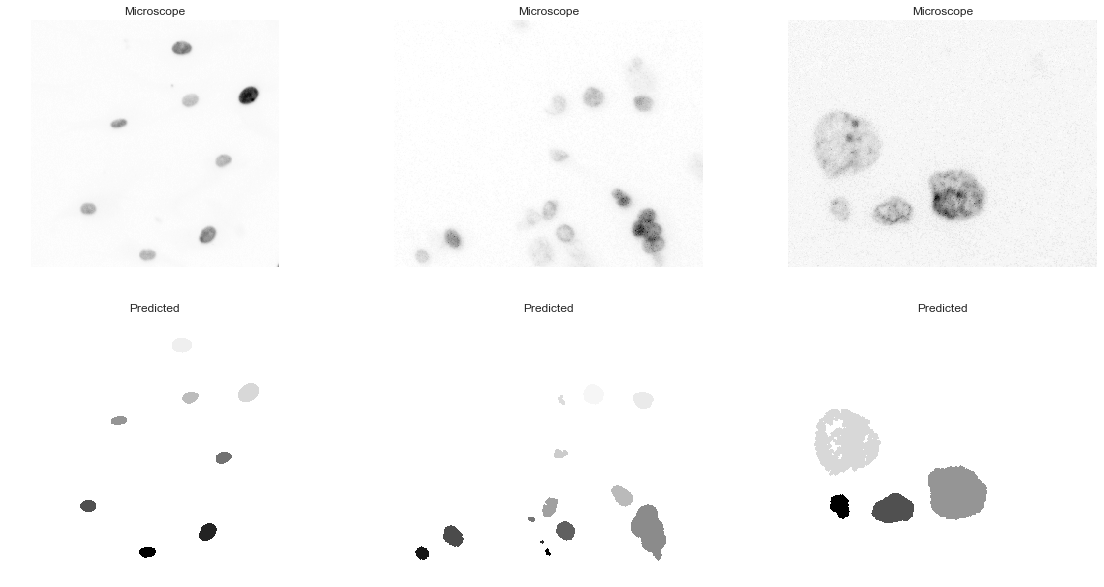

In [190]:
n_img = 3
fig, m_axs = plt.subplots(2, n_img, figsize = (20, 10))
for (_, d_row), (c_im, c_lab) in zip(test_img_df.sample(n_img).iterrows(), 
                                     m_axs.T):
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')

In [29]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

In [191]:
test_img_df['rles'] = test_img_df['masks'].map(lambda x: list(prob_to_rles(x)))

In [192]:
out_pred_list = []
for _, c_row in test_img_df.iterrows():
    for c_rle in c_row['rles']:
        out_pred_list+=[dict(ImageId=c_row['ImageId'], 
                             EncodedPixels = ' '.join(np.array(c_rle).astype(str)))]
out_pred_df = pd.DataFrame(out_pred_list)
print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
out_pred_df.sample(3)

(2186, 'regions found for', 65, 'images')


,EncodedPixels,ImageId
387,110777 5 111300 7 111823 9 112347 10 112870 11...,3c4c675825f7509877bc10497f498c9a2e3433bf922bd8...
840,80752 3 81011 5 81271 5 81530 7 81791 5 82051 ...,52b267e20519174e3ce1e1994b5d677804b16bc670aa5f...
743,58369 2 58625 3 58881 4 59137 4 59393 5 59649 ...,4be73d68f433869188fe5e7f09c7f681ed51003da6aa5d...


In [193]:
out_pred_df[['ImageId', 'EncodedPixels']].to_csv('predictions.csv', index = False)